In [1]:
import kagglehub
import pandas as pd
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

100%|██████████| 67.4k/67.4k [00:00<00:00, 20.0MB/s]

Extracting files...


## Importing Required Libraries
We start by importing necessary Python libraries that will help in data processing, visualization, and model training:
- `pandas`
- `numpy`
- `matplotlib` & `seaborn`
- `sklearn`

This step ensures we have all the required tools to clean, analyze, and train a predictive model.


In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

##Data Loading
Here, we will load the dataset into a Pandas DataFrame. This allows us to easily manipulate and analyze the data. We will also take a quick look at the first few rows of the dataset to understand its structure and the types of data it contains.

In [3]:
file_path = f"{path}/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(file_path)

##Data Exploration
In this section, we will perform exploratory data analysis (EDA) to gain insights into the dataset. This includes checking for missing values, understanding the distribution of features, and visualizing relationships between variables. EDA is crucial for identifying patterns and potential issues in the data.

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


##Checking for Missing Values
We will examine the dataset for any missing values, as they can significantly impact the performance of our model. Understanding the extent of missing data will help us decide on appropriate strategies for handling it.

In [5]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


## Understanding the Structure of the Dataset
Using `df.info()`, we check:
- The number of rows and columns.
- Data types of each column (categorical vs. numerical).
- Any missing values that need to be addressed.

Understanding the dataset structure helps in preparing the data for further processing and ensures the data is in a usable format for training models.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


##Visualizing Feature Distributions
We will create visualizations to understand the distribution of key features, such as age, average glucose level, and BMI. This will help us identify any outliers or unusual patterns that may need to be addressed.

<Axes: ylabel='count'>

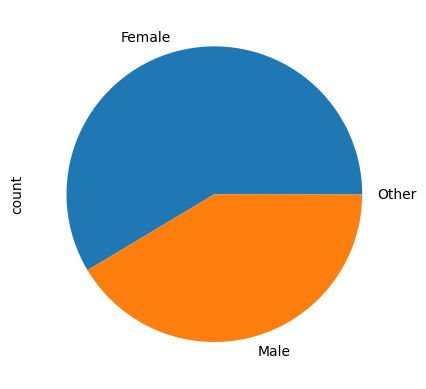

In [7]:
df['gender'].value_counts().plot(kind="pie")

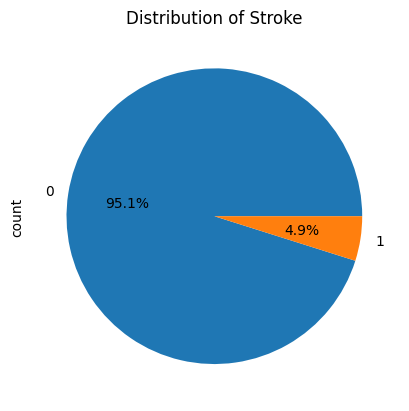

In [8]:
df['stroke'].value_counts().plot(kind="pie", autopct='%1.1f%%', color='blue')
plt.title('Distribution of Stroke')
plt.show()


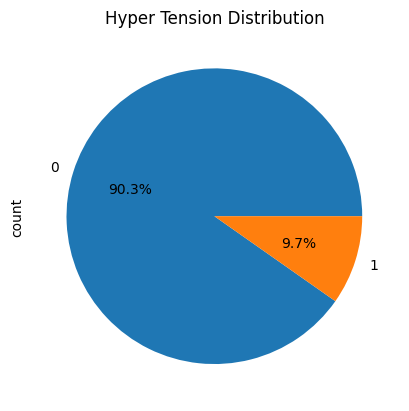

In [9]:
df['hypertension'].value_counts().plot(kind='pie', autopct = '%1.1f%%')
plt.title('Hyper Tension Distribution')
plt.show()

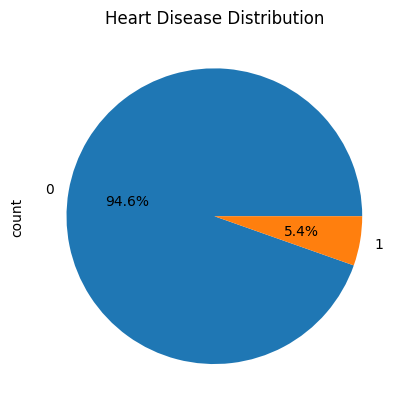

In [10]:
df['heart_disease'].value_counts().plot(kind='pie', autopct = '%1.1f%%')
plt.title('Heart Disease Distribution')
plt.show()

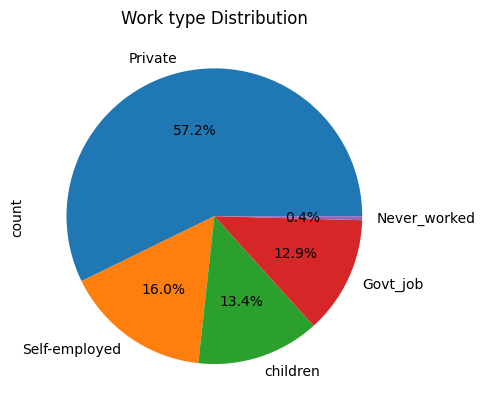

In [11]:
df['work_type'].value_counts().plot(kind='pie', autopct = '%1.1f%%')
plt.title('Work type Distribution')
plt.show()

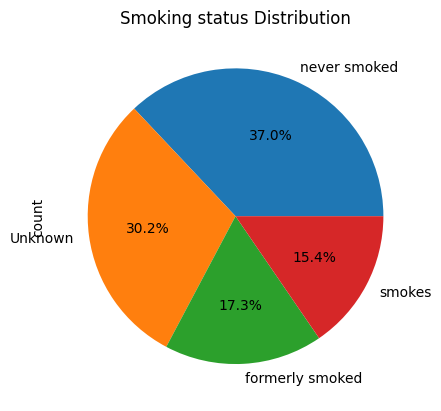

In [12]:
df['smoking_status'].value_counts().plot(kind='pie', autopct = '%1.1f%%')
plt.title('Smoking status Distribution')
plt.show()

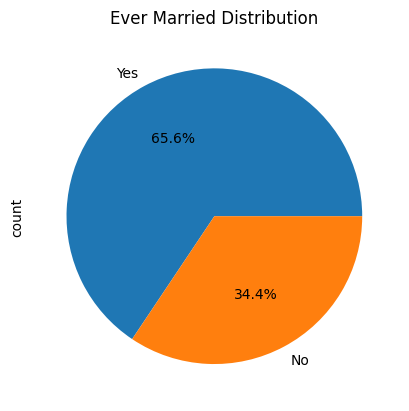

In [13]:
df['ever_married'].value_counts().plot(kind='pie', autopct = '%1.1f%%')
plt.title('Ever Married Distribution')
plt.show()

<Axes: xlabel='bmi', ylabel='Count'>

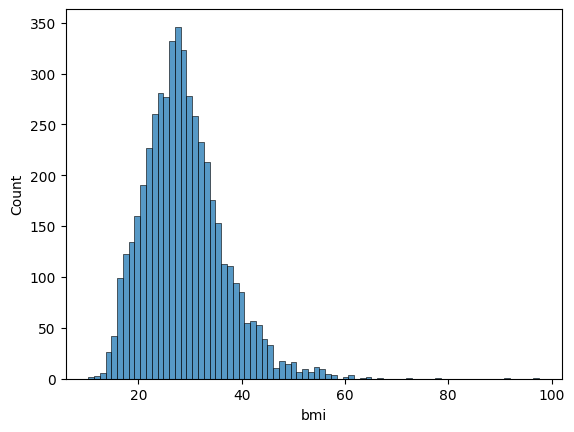

In [14]:
sns.histplot(data=df['bmi'])

<Axes: xlabel='avg_glucose_level', ylabel='Count'>

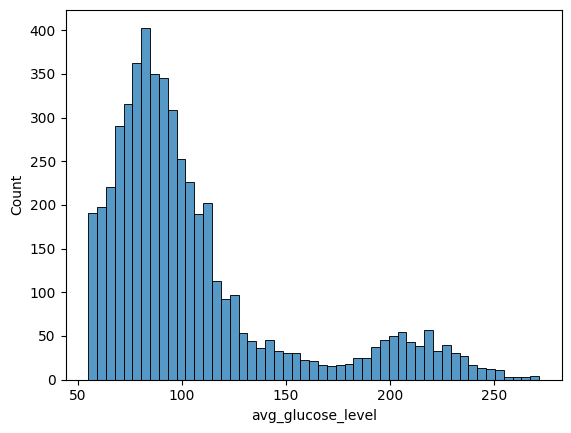

In [15]:
sns.histplot(data=df['avg_glucose_level'])

##Data Preprocessing
Before building the model, we need to preprocess the data. This includes handling missing values, encoding categorical variables, and scaling numerical features. Proper preprocessing ensures that the model can learn effectively from the data.

In [16]:
Gender_medianBMI = df.groupby('gender')['bmi'].median()
print(Gender_medianBMI)

gender
Female    27.8
Male      28.4
Other     22.4
Name: bmi, dtype: float64


In [17]:
age_medianBMI = df.groupby('age')['bmi'].apply(lambda x: x.median())
print(age_medianBMI)

age
0.08     15.50
0.16     13.90
0.24     18.50
0.32     17.80
0.40     15.85
         ...  
78.00    27.50
79.00    28.20
80.00    28.70
81.00    27.65
82.00    27.10
Name: bmi, Length: 104, dtype: float64


##Handling Missing Values
We will decide on a strategy to handle any missing values identified in the previous section. This could involve filling missing values with the mean, median, or mode, or even dropping rows or columns with excessive missing data.

In [18]:
medianBMI_by_age = df.groupby('age')['bmi'].transform('median')
df['bmi'].fillna(medianBMI_by_age,inplace=True)

<ipython-input-18-17d5f1bad5a1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(medianBMI_by_age,inplace=True)


In [19]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


 ID Column wont be useful for training the model, Hence dropped ID column from the DataFrame

In [21]:
df.drop('id',axis=1,inplace=True)

In [22]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.45,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


## Feature Selection and Data Preparation
Before training a machine learning model, we must:
1. Convert categorical data into numerical format using encoding techniques (e.g., one-hot encoding).
2. Normalize numerical data so that no feature dominates due to its scale.
3. Split the dataset into:
   - **Training set** (used to train the model).
   - **Testing set** (used to evaluate model performance).

 We ensure that our model generalizes well to new, unseen data.


In [23]:
df_new = df.copy()
df_new = pd.get_dummies(df_new,columns = ['gender','ever_married','work_type','Residence_type','smoking_status'],drop_first = True)
df_new

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60,1,True,False,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,29.45,1,False,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.50,1,True,False,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.40,1,False,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.00,1,False,False,True,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.70,0,False,False,True,False,True,False,False,True,False,True,False
5106,81.0,0,0,125.20,40.00,0,False,False,True,False,False,True,False,True,False,True,False
5107,35.0,0,0,82.99,30.60,0,False,False,True,False,False,True,False,False,False,True,False
5108,51.0,0,0,166.29,25.60,0,True,False,True,False,True,False,False,False,True,False,False


In [24]:
x = df_new
y = df_new.pop('stroke')
x.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60,True,False,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,29.45,False,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.50,True,False,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.40,False,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.00,False,False,True,False,False,True,False,False,False,True,False


In [25]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   gender_Male                     5110 non-null   bool   
 6   gender_Other                    5110 non-null   bool   
 7   ever_married_Yes                5110 non-null   bool   
 8   work_type_Never_worked          5110 non-null   bool   
 9   work_type_Private               5110 non-null   bool   
 10  work_type_Self-employed         5110 non-null   bool   
 11  work_type_children              5110 non-null   bool   
 12  Residence_type_Urban            51

In [26]:
numerical_cols = ['age', 'bmi','avg_glucose_level']
scaler = MinMaxScaler()
x[numerical_cols] = scaler.fit_transform(x[numerical_cols])
print("Scaled Numerical Features:")
print(x[numerical_cols].head())

Scaled Numerical Features:
        age       bmi  avg_glucose_level
0  0.816895  0.301260           0.801265
1  0.743652  0.219359           0.679023
2  0.975586  0.254296           0.234512
3  0.597168  0.276060           0.536008
4  0.963379  0.156930           0.549349


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.3, random_state=42)

## Handling Class Imbalance with SMOTEENN
In real-world medical datasets, stroke occurrences are often much fewer compared to non-stroke cases. This results in an **imbalanced dataset**, where the model may become biased towards predicting the majority class (non-stroke).  
To tackle this issue, we use **SMOTEENN (Synthetic Minority Over-sampling Technique + Edited Nearest Neighbors)**, which combines **oversampling** and **undersampling** techniques:  
### **How It Helps the Model**
- Prevents the model from being biased towards the majority class.  
- Helps improve **recall**, ensuring that stroke cases are detected more effectively.  
- Reduces the impact of noisy data, making the dataset more representative of actual stroke patterns.  

By applying **SMOTEENN**, we achieve a **better balance** between classes, leading to a **more reliable and fair stroke prediction model**.


In [28]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_train, Y_train = smote_enn.fit_resample(X_train, Y_train)
X_test, Y_test = smote_enn.fit_resample(X_test, Y_test)

##Model Training
In this section, we will train our stroke prediction model using a Random Forest Classifier. This algorithm is chosen for its robustness and ability to handle both numerical and categorical data effectively. We will fit the model to the training data and prepare it for evaluation.

## Training with XGBoost Classifier
XGBoost (Extreme Gradient Boosting) is a powerful ensemble learning algorithm that efficiently handles structured/tabular data. In stroke prediction, XGBoost is beneficial because:
1. **Handles Imbalanced Data Well**: Since stroke cases are rare, XGBoost uses **weighted loss functions** to prevent bias towards the majority class.
2. **Feature Importance**: It automatically determines which features contribute most to stroke prediction.
3. **Fast and Optimized**: XGBoost is optimized for both speed and performance using parallel processing and tree pruning techniques.

Overall, XGBoost is a **robust, interpretable, and efficient model** for stroke prediction, providing a strong baseline for performance evaluation.


In [29]:
stroke_model_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.01,
    max_depth=8,
    n_estimators=300,
)

stroke_model_xgb.fit(X_train, Y_train)

y_pred = stroke_model_xgb.predict(X_test)
y_pred_proba = stroke_model_xgb.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))
print("\nROC-AUC Score:")
print(roc_auc_score(Y_test, y_pred_proba))

Confusion Matrix:
[[1021  151]
 [ 345  970]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1172
           1       0.87      0.74      0.80      1315

    accuracy                           0.80      2487
   macro avg       0.81      0.80      0.80      2487
weighted avg       0.81      0.80      0.80      2487


ROC-AUC Score:
0.904426153985907


## Training with Neural Network (Deep Learning Approach)
A Neural Network (NN) is a powerful deep learning model that can **capture complex patterns** in data. We use a **fully connected feedforward neural network** to predict stroke risk.


### **Model Architecture:**
- **Layer 1 (Input)**: 64 neurons, **ReLU activation** → Extracts high-level features.
- **Layer 2**: 32 neurons, **ReLU activation** + Dropout (20%) → Prevents overfitting.
- **Layer 3**: 16 neurons, **ReLU activation** + Dropout (10%) → Learns finer details.
- **Output Layer**: 1 neuron, **Sigmoid activation** → Outputs probability (0 = No Stroke, 1 = Stroke).

Neural networks are effective for **finding hidden patterns in stroke data**, complementing traditional models like XGBoost. However, they require **more training time** and **larger datasets** to perform optimally.


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

stroke_model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

stroke_model_nn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

stroke_model_nn.fit(X_train, Y_train, epochs=100, batch_size=62)

Y_pred_nn = (stroke_model_nn.predict(X_test)>0.5).astype(int)
print("Neural Network Results:")
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred_nn))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_nn))
print("ROC-AUC Score:", roc_auc_score(Y_test, stroke_model_nn.predict(X_test)))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.6037 - loss: 0.6709
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7495 - loss: 0.5151
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8082 - loss: 0.4364
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8284 - loss: 0.3964
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8521 - loss: 0.3650
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8503 - loss: 0.3578
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8671 - loss: 0.3274
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8698 - loss: 0.3164
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8699 - loss: 0.3069
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8790 - loss: 0.2964
Epoch 11/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8818 - loss: 0.2960
Epoch 12/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

In [31]:
Y_pred_nn = (stroke_model_nn.predict(X_train)>0.5).astype(int)
print("Neural Network Results:")
print("Confusion Matrix:\n", confusion_matrix(Y_train, Y_pred_nn))
print("\nClassification Report:\n", classification_report(Y_train, Y_pred_nn))
print("ROC-AUC Score:", roc_auc_score(Y_train, stroke_model_nn.predict(X_train)))


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Results:
Confusion Matrix:
 [[2674  151]
 [  87 3008]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      2825
           1       0.95      0.97      0.96      3095

    accuracy                           0.96      5920
   macro avg       0.96      0.96      0.96      5920
weighted avg       0.96      0.96      0.96      5920

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
ROC-AUC Score: 0.993815088567058


## XGBoost Model Performance
- **Accuracy: 80%**, **Recall: 0.74**, **ROC-AUC: 0.90**
- **Strengths:** High recall (detects more strokes), fast training, good precision.
- **Weaknesses:** Misses some stroke cases, could improve further with hyperparameter tuning.
- **Best for:** High recall, handling imbalanced data efficiently.

## Neural Network Model Performance
- **Accuracy: 73%**, **Recall: 0.61**, **ROC-AUC: 0.85**
- **Strengths:** Higher **ROC-AUC**, captures complex patterns, deep learning-based.
- **Weaknesses:** Lower recall (misses more strokes), slower training.
- **Best for:** Capturing deeper patterns, generalization.

## XGBoost vs Neural Network
| Model  | Accuracy | Recall (Stroke) | ROC-AUC |
|--------|----------|-----------------|---------|
| **XGBoost** | **80%** | **0.74** | **0.90** |
| **Neural Network** | 73% | 0.61 | **0.85** |

### **Which is Better?**
**XGBoost** → If you prioritize detecting more strokes (higher recall).  
**Neural Network** → If you need better ranking performance (higher ROC-AUC).  



In [32]:
import pickle

with open('stroke_model_xgb.pkl', 'wb') as f:
    pickle.dump(stroke_model_xgb, f)

In [34]:
stroke_model_nn.save('stroke_model_nn.h5')